In [159]:
# 1. Import the following libraries: 
# pip install pandas numpy matplotlib statsmodels scikit-learn

# pandas (for data manipulation)
import pandas as pd
    
# numpy (for numerical operations)
import numpy as np
    
# matplotlib (for data visualization)
import matplotlib.pyplot as plt 
    
# statsmodels (to use ARIMA)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# scikit-learn (for error metrics)
from sklearn.metrics import mean_squared_error

In [160]:
# 2. Importing stock data using AlphaVantage API

# !pip install alpha_vantage

from alpha_vantage.timeseries import TimeSeries

#Free API key
key = 'UO4WWNLT3XIKJ6EI'

# Create TimeSeries object
ts = TimeSeries(key, output_format='pandas') #requires input of key and output format (default is json)

# Sample API Call for Tesla
#objects come with a data and a meta component (will likely only need data component), require a stock symbol + interval + output size
predata, meta = ts.get_daily('TSLA', outputsize='full')
data = predata[:1000]


In [161]:
print(data)
print(len(data))

            1. open   2. high    3. low  4. close    5. volume
date                                                          
2024-01-12   220.08  225.3400  217.1501    218.89  123043812.0
2024-01-11   230.57  230.9300  225.3700    227.22  105873612.0
2024-01-10   235.10  235.5000  231.2900    233.94   91628502.0
2024-01-09   238.11  238.9646  232.0400    234.96   96705664.0
2024-01-08   236.14  241.2500  235.3000    240.45   85166580.0
...             ...       ...       ...       ...          ...
2020-01-30   632.42  650.8800  618.0000    640.81   29005676.0
2020-01-29   575.69  589.8000  567.4300    580.99   18216672.0
2020-01-28   568.49  576.8100  558.0800    566.90   11788493.0
2020-01-27   541.99  564.4400  539.2800    558.02   13608068.0
2020-01-24   570.63  573.8600  554.2600    564.82   14353600.0

[1000 rows x 5 columns]
1000


In [162]:
# 3. Modify the dataset

# Keep relevant columns - closing price and date
closing_data = data['4. close']
print(closing_data)

date
2024-01-12    218.89
2024-01-11    227.22
2024-01-10    233.94
2024-01-09    234.96
2024-01-08    240.45
               ...  
2020-01-30    640.81
2020-01-29    580.99
2020-01-28    566.90
2020-01-27    558.02
2020-01-24    564.82
Name: 4. close, Length: 1000, dtype: float64


In [163]:
# 4. Separate the data into training and testing datasets

# Create a DataFrame using the closing price data
df = pd.DataFrame(closing_data)
print(df)

# Split data into 70-30 training-testing data sets
# Sort df by ascending order (most recent date comes last)
df.sort_index(ascending=True, inplace=True)
print(df)


# # Testing daily dataset instead of by minute
# hourly_data = df.resample('D').mean()
# df2 = pd.DataFrame(hourly_data)



# train_size represents the first 90% of all rows; use this index to slice the data
train_size = int(len(df) * 0.90)

# Training data will include all rows starting from the first row up to the row indicated by 'train_size'
train_data = df.iloc[:train_size]
# The rest 10% will be included in testing data
test_data = df.iloc[train_size:]

print("Training data: ", train_data)
print("Testing data: ", test_data)

            4. close
date                
2024-01-12    218.89
2024-01-11    227.22
2024-01-10    233.94
2024-01-09    234.96
2024-01-08    240.45
...              ...
2020-01-30    640.81
2020-01-29    580.99
2020-01-28    566.90
2020-01-27    558.02
2020-01-24    564.82

[1000 rows x 1 columns]
            4. close
date                
2020-01-24    564.82
2020-01-27    558.02
2020-01-28    566.90
2020-01-29    580.99
2020-01-30    640.81
...              ...
2024-01-08    240.45
2024-01-09    234.96
2024-01-10    233.94
2024-01-11    227.22
2024-01-12    218.89

[1000 rows x 1 columns]
Training data:              4. close
date                
2020-01-24    564.82
2020-01-27    558.02
2020-01-28    566.90
2020-01-29    580.99
2020-01-30    640.81
...              ...
2023-08-15    232.96
2023-08-16    225.60
2023-08-17    219.22
2023-08-18    215.49
2023-08-21    231.28

[900 rows x 1 columns]
Testing data:              4. close
date                
2023-08-22    233.19
2023-08-23   

<AxesSubplot:xlabel='date'>

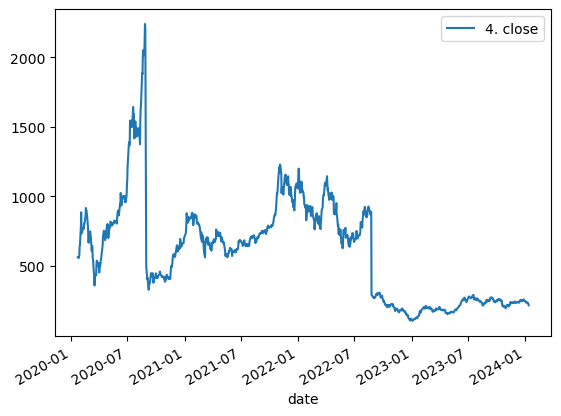

In [164]:
# 5.1 Visualize the data

# Plot the data for visualization
df.plot()

In [165]:
# 5.2 Conduct the ADF test and determine the value for d 

# Conduct the ADF test, which determines if the data is stationary or not
result = adfuller(df)

# Keeps track of the number of times differencing was needed 
d = 0

# If the data is not stationary, differencing is needed to convert it into stationary data
# The p-value has to be less than 0.05 for the dataset to be considered stationary 
while True:
    print('p-value: ', result[1])
    if result[1] < 0.05:
        break
    else:
        result = adfuller(df.diff().dropna())
        d += 1

print('\nd value: ', d)

p-value:  0.06724542405860022
p-value:  0.0

d value:  1


In [166]:
# 6. Optimize the parameters (p, d, q) and create the ARIMA model

    # Determine (p,d,q) based on the data's characteristics
    # ACF plot is used to determine p (autoregressive AR)
    # PACF plot is used to determine q (moving average MA)
    
    # Create the ARIMA model object and fit it to the data
    
    # Examples of useful python code:
    # p, d, q = 1, 1, 1
    # model = ARIMA(data, order(p,d,q))
    # model_fit = model.fit()

            4. close
date                
2020-01-24    564.82
2020-01-27    558.02
2020-01-28    566.90
2020-01-29    580.99
2020-01-30    640.81
...              ...
2024-01-08    240.45
2024-01-09    234.96
2024-01-10    233.94
2024-01-11    227.22
2024-01-12    218.89

[1000 rows x 1 columns]
1000


<Figure size 1500x600 with 0 Axes>

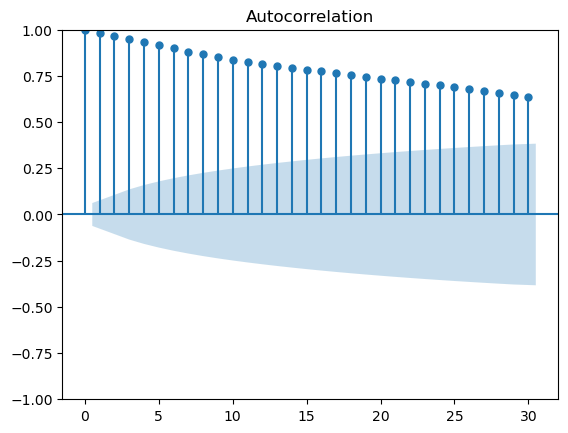

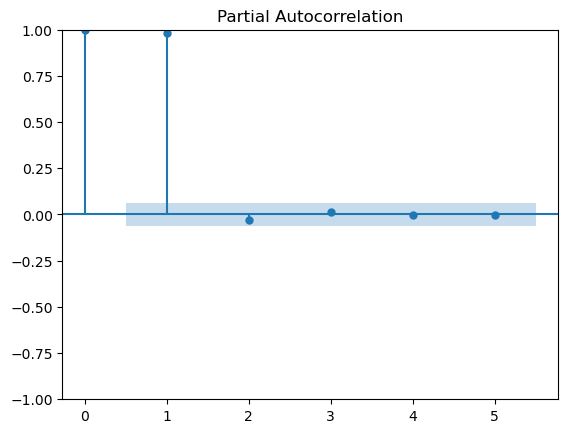

In [167]:
# # Preprocess the data to show daily instead of by minute
# hourly_data = df.resample('D').mean()
# df = pd.DataFrame(hourly_data)


print(df.dropna())
print(len(df.dropna()))


# ACF plot to determine q value (visu)
plt.figure(figsize=(15, 6))
plot_acf(df.dropna())
plt.show()

# PACF plot to determine p value 
plot_pacf(df.dropna(), lags=5)
plt.show()



In [168]:
# 6.1 Determine the best p and q values
# The best p,q,d values will produce the lowest aic value 

import warnings
warnings.filterwarnings("ignore")

# Defines ranges for p and q
p = q = range(0, 4)

# List to store all pdq combinations
pdq = []
# Appends each combination of p,d,q to the list
for p_value in p:
    for q_value in q:
        pdq.append((p_value, d, q_value))

# Initialize best aic to start at infinity
best_aic = float('inf')  
# Initialize best pqd combination 
best_pdq = None

# Test each combination 
for combination in pdq:
    # Fit the arima model 
    model = ARIMA(df, order=(combination))
    model_fit = model.fit()
    
    # If the aic value is lower than the current best aic, it will be replaced
    if model_fit.aic < best_aic:
        best_aic = model_fit.aic
        best_pdq = combination

# Extract the p and q values
p = best_pdq[0]
q = best_pdq[2]

print('p value: ', p)
print('q value: ', q)

p value:  2
q value:  3


In [169]:
# 6.2 Create the ARIMA model with the p, d, q values determined
model = ARIMA(df, order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               4. close   No. Observations:                 1000
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -5586.236
Date:                Tue, 16 Jan 2024   AIC                          11184.471
Time:                        14:51:07   BIC                          11213.912
Sample:                             0   HQIC                         11195.661
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6029      0.053    -11.332      0.000      -0.707      -0.499
ar.L2         -0.9506      0.031    -30.235      0.000      -1.012      -0.889
ma.L1          0.6283      0.103      6.085      0.0

In [170]:
# 6.3 Train the ARIMA model with the training data and the p, d, q values determined
model = ARIMA(train_data['4. close'], order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               4. close   No. Observations:                  900
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -5073.941
Date:                Tue, 16 Jan 2024   AIC                          10159.882
Time:                        14:51:10   BIC                          10188.690
Sample:                             0   HQIC                         10170.888
                                - 900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6039      0.056    -10.773      0.000      -0.714      -0.494
ar.L2         -0.9535      0.032    -29.711      0.000      -1.016      -0.891
ma.L1          0.6295      0.113      5.581      0.0

In [171]:
# 7. Make out-of-sample predictions (forecasting)

# fit the model to the DataFrame which includes all of the given data
model = ARIMA(train_data, order=(p,d,q))
model_fit = model.fit()

# make future predictions for the next week
forecast_steps = 7
print("steps: ", forecast_steps)
# use steps parameter for # of future steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)
print("Predicted value:\n", forecast)

print("\nActual value:\n", test_data.dropna())

steps:  7
Predicted value:
 900    233.173390
901    234.944269
902    232.151990
903    232.149887
904    234.813529
905    233.206837
906    231.637474
Name: predicted_mean, dtype: float64

Actual value:
             4. close
date                
2023-08-22    233.19
2023-08-23    236.86
2023-08-24    230.04
2023-08-25    238.59
2023-08-28    238.82
...              ...
2024-01-08    240.45
2024-01-09    234.96
2024-01-10    233.94
2024-01-11    227.22
2024-01-12    218.89

[100 rows x 1 columns]
